# Fig S5: Shape descriptors as a function of distance from the fovea

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

2018-08-15 17:09:14,938 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [3]:
subjects = subjectdata.index.sort_values()

In [12]:
Xy = []
for subject in subjects:
    X, y = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'),
                                  subject=subject, amp=2.0, random_state=42)
    y['orientation'] = np.rad2deg(y['orientation'])
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    y['dist2fovea'] = pd.Series([np.sqrt(argus[row['electrode']].x_center ** 2 + 
                                 argus[row['electrode']].y_center ** 2)
                                 for _, row in y.iterrows()], index=y.index)
    Xy.append(pd.concat((pd.concat(features), pd.concat(targets).drop(columns=['electrode', 'image'])), axis=1))
Xy = pd.concat(Xy)

In [13]:
gb = Xy.groupby('subject')

In [14]:
cols = ['area', 'orientation', 'eccentricity']
ylabels = ['area (pixels)', 'orientation (deg)', 'elongation']
markers = ['o', 's', 'v', '^']

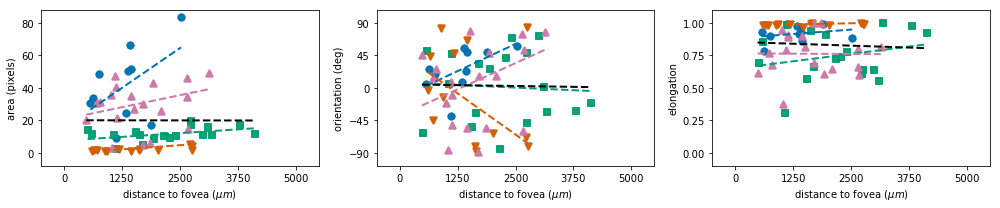

In [19]:
yticks = [[0, 80], [-90, 90], [0, 1], [0, 1]]
ylimits = [[-8, 88], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
    
fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim, ytick in zip(cols, axes, ylabels, ylimits, yticks):
    for (subject, data), marker in zip(gb, markers):
        ax.scatter(data['dist2fovea'], data[col], alpha=0.5, marker=marker,
                   linewidth=2, label=None)
        # Linear fit for subject:
        slope, intercept, rval, pval, _ = stats.linregress(data['dist2fovea'], data[col])
        reg = lambda x: x * slope + intercept
        a = ax.axis()
        ax.plot([np.min(data['dist2fovea']), np.max(data['dist2fovea'])],
                [reg(a[0]), reg(a[1])], '--', linewidth=2, label=subject)
        
    # Linear fit across all subjects:
    slope, intercept, rval, pval, _ = stats.linregress(Xy['dist2fovea'], Xy[col])
    reg = lambda x: x * slope + intercept
    a = ax.axis()
    ax.plot([np.min(Xy['dist2fovea']), np.max(Xy['dist2fovea'])], [reg(a[0]), reg(a[1])],
            'k--', linewidth=2, label='all subjects')
    
    ax.set_xlim(-500, 5500)
    ax.set_xticks(np.linspace(0, 5000, 5))
    ax.set_xlabel('distance to fovea ($\mu m$)')
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ytick, num=5))
    ax.set_ylabel(ylabel)
    if col == 'elongation':
        ax.legend(loc='upper right', ncol=5, bbox_to_anchor=(1, 1.2))

fig.tight_layout()
fig.savefig('fig5a-fovea.eps')

In [20]:
for col in cols:
    print(col)
    for subject, data in gb:
        _, _, rval, pval, _ = stats.linregress(data['dist2fovea'], data[col])
        print('%s: r=%.3f, p=%f' % (subject, rval, pval))
    _, _, rval, pval, _ = stats.linregress(Xy['dist2fovea'], Xy[col])
    print('All subjects: r=%.2f, p=%f\n' % (rval, pval))

area
S1: r=0.464, p=0.002584
S2: r=0.403, p=0.000447
S3: r=0.669, p=0.000000
S4: r=0.204, p=0.076992
All subjects: r=-0.00, p=0.979437

orientation
S1: r=0.551, p=0.000229
S2: r=-0.055, p=0.645776
S3: r=-0.297, p=0.032203
S4: r=0.258, p=0.024531
All subjects: r=-0.01, p=0.826624

eccentricity
S1: r=0.232, p=0.149924
S2: r=0.225, p=0.057559
S3: r=0.391, p=0.004207
S4: r=-0.006, p=0.958828
All subjects: r=-0.05, p=0.400411

